<h1 align="center"> Credit Fraud Detector </h1>

**Note:** There are still aspects of this kernel that will be subjected to changes. I've noticed a recent increase of interest towards this kernel so I will focus more on the steps I took and why I took them to make it clear why I took those steps.

<h2>Before we Begin:  </h2>
If you liked my work, please upvote this kernel since it will keep me motivated to perform more in-depth reserach towards this subject and will look for more efficient ways so that our models are able to detect more accurately both fraud and non-fraud transactions.

<h2> Introduction </h2>
In this kernel we will use various predictive models to see how accurate they  are in detecting whether a transaction is a normal payment or a fraud. As described in the dataset, the features are scaled and the names of the features are not shown due to privacy reasons. Nevertheless, we can still analyze some important aspects of the dataset. Let's start!


<h2> Our Goals: </h2>
<ul>
<li> Understand the little distribution of the "little" data that was provided to us. </li>
<li> Create a 50/50 sub-dataframe ratio of "Fraud" and "Non-Fraud" transactions. (NearMiss Algorithm) </li>
<li> Determine the Classifiers we are going to use and decide which one has a higher accuracy. </li>
<li>Create a Neural Network and compare the accuracy to our best classifier. </li>
<li>Understand common mistaked made with imbalanced datasets. </li>
</ul>


<h2> Outline: </h2>
I. <b>Understanding our data</b><br>
a) [Gather Sense of our data](#gather)<br><br>

II. <b>Preprocessing</b><br>
a) [Scaling and Distributing](#distributing)<br>
b) [Splitting the Data](#splitting)<br><br>

III. <b>Random UnderSampling and Oversampling</b><br>
a) [Distributing and Correlating](#correlating)<br>
b) [Anomaly Detection](#anomaly)<br>
c) [Dimensionality Reduction and Clustering (t-SNE)](#clustering)<br>
d) [Classifiers](#classifiers)<br>
e) [A Deeper Look into Logistic Regression](#logistic)<br>
f) [Oversampling with SMOTE](#smote)<br><br>

IV. <b>Testing </b><br>
a) [Testing with Logistic Regression](#testing_logistic)<br>
b) [Neural Networks Testing (Undersampling vs Oversampling)](#neural_networks)

<h2>Correcting Previous Mistakes from Imbalanced Datasets: </h2>
<ul>
<li> Never test on the oversampled or undersampled dataset.</li>
<li>If we want to implement cross validation, remember to oversample or undersample your training data <b>during</b> cross-validation, not before! </li>
<li> Don't use <b>accuracy score </b> as a metric with imbalanced datasets (will be usually high and misleading), instead use <b>f1-score, precision/recall score or confusion matrix </b></li>
</ul>


<h2> References: </h2>
<ul> 
<li>Hands on Machine Learning with Scikit-Learn & TensorFlow by Aurélien Géron (O'Reilly). CopyRight 2017 Aurélien Géron  </li>
<li><a src="https://www.youtube.com/watch?v=DQC_YE3I5ig&t=794s" > Machine Learning - Over-& Undersampling - Python/ Scikit/ Scikit-Imblearn </a>by Coding-Maniac</li>
<li><a src="https://www.kaggle.com/lane203j/auprc-5-fold-c-v-and-resampling-methods"> auprc, 5-fold c-v, and resampling methods
</a> by Jeremy Lane (Kaggle Notebook) </li>
</ul>

## Gather Sense of Our Data:
<a id="gather"></a>
The first thing we must do is gather a <b> basic sense </b> of our data. Remember, except for the <b>transaction</b> and <b>amount</b> we dont know what the other columns are (due to privacy reasons). The only thing we know, is that those columns that are unknown have been scaled already.   

<h3> Summary: </h3>
<ul>
<li>The transaction amount is relatively <b>small</b>. The mean of all the mounts made is approximately USD 88. </li>
<li>There are no <b>"Null"</b> values, so we don't have to work on ways to replace values. </li>
<li> Most of the transactions were <b>Non-Fraud</b> (99.83%) of the time, while <b>Fraud</b> transactions occurs (017%) of the time in the dataframe. </li>
</ul>

<h3> Feature Technicalities: </h3>
<ul>
<li> <b>PCA Transformation: </b>  The description of the data says that all the features went through a PCA transformation (Dimensionality Reduction technique) (Except for time and amount).</li>
<li> <b>Scaling:</b> Keep in mind that in order to implement a PCA transformation features need to be previously scaled. (In this case, all the V features have been scaled or at least that is what we are assuming the people that develop the dataset did.)</li>
</ul>

In [86]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Imported Libraries

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import collections


# Other Libraries
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")


df = pd.read_csv('../input/creditcard.csv')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [2]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [3]:
# Good No Null Values!
df.isnull().sum()

Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64

In [4]:
df.columns

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')

In [5]:
# The classes are heavily skewed we need to solve this issue later.
print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df)*100,2),'% of the dataset')

No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset


**Note:**  Notice how imbalanced is our original dataset! Most of the transactions are non-fraud. If we use this dataframe as the base for our predictive models and analysis we might get a lot of errors and our algorithms will probably overfit since it will "assume" that most transactions are not fraud. But we don't want our model to assume, we want our model to detect patterns that give signs of fraud!

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

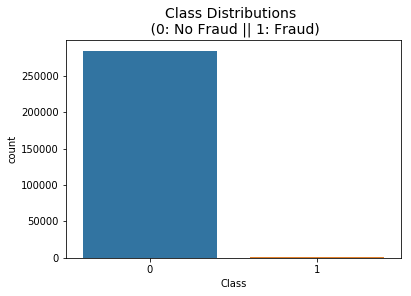

In [6]:

sns.countplot('Class', data=df)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

**Distributions:** By seeing the distributions we can have an idea how skewed are these features, we can also see further distributions of the other features. There are techniques that can help the distributions be less skewed which will be implemented in this notebook in the future.

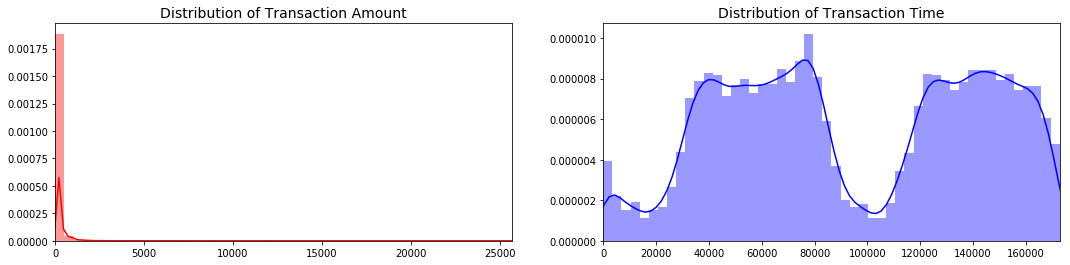

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))


amount_val = df['Amount'].values
time_val = df['Time'].values

sns.distplot(amount_val, ax=ax[0], color='r')
ax[0].set_title('Distribution of Transaction Amount', fontsize=14)
ax[0].set_xlim([min(amount_val), max(amount_val)])

sns.distplot(time_val,ax=ax[1],color='b')
ax[1].set_title('Distribution of Transaction Time', fontsize=14)
ax[1].set_xlim([min(time_val),max(time_val)])


plt.show()

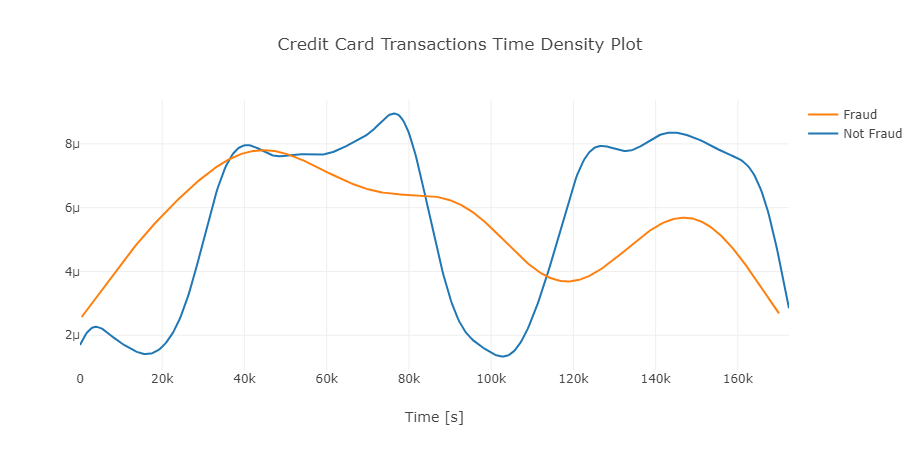

In [89]:
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
class_0 = df.loc[df['Class'] == 0]["Time"]
class_1 = df.loc[df['Class'] == 1]["Time"]

hist_data = [class_0, class_1]
group_labels = ['Not Fraud', 'Fraud']

fig = ff.create_distplot(hist_data, group_labels, show_hist=False, show_rug=False)
fig['layout'].update(title='Credit Card Transactions Time Density Plot', xaxis=dict(title='Time [s]'))
iplot(fig, filename='dist_only')

<h2> Scaling and Distributing </h2>
<a id="distributing"></a>
In this phase of our kernel, we will first scale the columns comprise of <b>Time</b> and <b>Amount </b>. Time and amount should be scaled as the other columns. On the other hand, we need to also create a sub sample of the dataframe in order to have an equal amount of Fraud and Non-Fraud cases, helping our algorithms better understand patterns that determines whether a transaction is a fraud or not.

<h3> What is a sub-Sample?</h3>
In this scenario, our subsample will be a dataframe with a 50/50 ratio of fraud and non-fraud transactions. Meaning our sub-sample will have the same amount of fraud and non fraud transactions.

<h3> Why do we create a sub-Sample?</h3>
In the beginning of this notebook we saw that the original dataframe was heavily imbalanced! Using the original dataframe  will cause the following issues:
<ul>
<li><b>Overfitting: </b>Our classification models will assume that in most cases there are no frauds! What we want for our model is to be certain when a fraud occurs. </li>
<li><b>Wrong Correlations:</b> Although we don't know what the "V" features stand for, it will be useful to understand how each of this features influence the result (Fraud or No Fraud) by having an imbalance dataframe we are not able to see the true correlations between the class and features. </li>
</ul>

<h3>Summary: </h3> 
<ul>
<li> <b>Scaled amount </b> and <b> scaled time </b> are the columns with scaled values. </li>
<li> There are <b>492 cases </b> of fraud in our dataset so we can randomly get 492 cases of non-fraud to create our new sub dataframe. </li>
<li>We concat the 492 cases of fraud and non fraud, <b>creating a new sub-sample. </b></li>
</ul>

In [8]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [9]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)

# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.783274,-0.994983,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.269825,-0.994983,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.983721,-0.994972,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.418291,-0.994972,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.670579,-0.994960,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


### Splitting the Data (Original DataFrame)
<a id="splitting"></a>
Before proceeding with the <b> Random UnderSampling technique</b> we have to separate the orginal dataframe. <b> Why? for testing purposes, remember although we are splitting the data when implementing Random UnderSampling or OverSampling techniques, we want to test our models on the original testing set not on the testing set created by either of these techniques.</b> The main goal is to fit the model either with the dataframes that were undersample and oversample (in order for our models to detect the patterns), and test it on the original testing set.  

In [10]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Frauds', round(df['Class'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['Class'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('Class', axis=1)
y = df['Class']

sss = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

    # We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
    # original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

    # Check the Distribution of the labels
    
    # Turn into an array
    original_Xtrain = original_Xtrain.values
    original_Xtest = original_Xtest.values
    original_ytrain = original_ytrain.values
    original_ytest = original_ytest.values

    # See if both the train and test label distribution are similarly distributed
    train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
    test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
    print('-' * 100)

    print('Label Distributions: \n')
    print(train_counts_label/ len(original_ytrain))
    print(test_counts_label/len(original_ytest))


No Frauds 99.83 % of the dataset
Frauds 0.17 % of the dataset
Train: [ 30473  30496  31002 ... 284804 284805 284806] Test: [    0     1     2 ... 57017 57018 57019]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827514 0.00172486]
[0.998262 0.001738]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 30473  30496  31002 ... 113964 113965 113966]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827514 0.00172486]
[0.998262 0.001738]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 81609  82400  83053 ... 170946 170947 170948]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827076 0.00172924]
[0.99827952 0.00172048]
Train: [     0      1      2 ... 284804 284805 284806] Test: [150654 150660 150661 ... 227866 227867 227868]


## Random Under-Sampling:
<img src="http://contrib.scikit-learn.org/imbalanced-learn/stable/_images/sphx_glr_plot_random_under_sampler_001.png">

In this phase of the project we will implement *"Random Under Sampling"* which basically consists of removing data in order to have a more <b> balanced dataset </b> and thus avoiding our models to overfitting.

#### Steps:
<ul>
<li>The first thing we have to do is determine how <b>imbalanced</b> is our class (use "value_counts()" on the class column to determine the amount for each label)  </li>
<li>Once we determine how many instances are considered <b>fraud transactions </b> (Fraud = "1") , we should bring the <b>non-fraud transactions</b> to the same amount as fraud transactions (assuming we want a 50/50 ratio), this will be equivalent to 492 cases of fraud and 492 cases of non-fraud transactions.  </li>
<li> After implementing this technique, we have a sub-sample of our dataframe with a 50/50 ratio with regards to our classes. Then the next step we will implement is to <b>shuffle the data</b> to see if our models can maintain a certain accuracy everytime we run this script.</li>
</ul>

**Note:** The main issue with "Random Under-Sampling" is that we run the risk that our classification models will not perform as accurate as we would like to since there is a great deal of <b>information loss</b> (bringing 492 non-fraud transaction  from 284,315 non-fraud transaction)

## RANDOM UNDERSAMPLING BEFORE CROSS VALIDATION-OVERFIT

In [11]:
# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
239938,0.348075,0.771355,1.980457,-0.131424,-1.916044,0.336039,0.289060,-0.730682,0.045192,-0.128517,1.180192,-0.830896,-0.946477,-0.353696,-1.047789,-1.274828,0.047181,0.145263,1.002525,0.275330,0.246712,-0.133479,-0.261279,-0.654931,0.163412,0.331575,-0.051162,-0.106397,-0.025449,-0.012937,0
93486,-0.307413,-0.237890,1.079524,0.872988,-0.303850,2.755369,0.301688,-0.350284,-0.042848,0.246625,-0.779176,-0.157696,1.928568,-0.935863,-2.431446,-1.633472,0.534337,1.425606,1.593529,1.178468,-1.568698,-0.252115,-0.023255,-0.158601,-0.038806,-0.060327,0.358339,0.076984,0.018936,0.060574,1
163278,0.098931,0.365618,2.093058,0.135069,-2.231134,0.181570,0.850612,-1.103204,0.787112,-0.504654,0.126075,0.019562,-0.843326,0.439721,0.547671,0.659519,0.406037,-0.497404,-0.487733,-0.407738,0.115130,-0.131899,0.105617,0.379197,-0.039245,0.517596,0.491019,-0.188235,-0.061183,-0.060653,0
153823,-0.275554,0.182462,-19.641857,14.706335,-22.801238,12.114672,-14.898113,0.840778,-28.011293,-11.919639,-8.960922,-18.913243,4.971249,-12.686308,-1.071443,-7.383370,-2.992430,-8.582309,-13.806568,-6.000359,1.422632,3.834649,-8.228874,3.318178,2.585212,0.195009,-1.194803,0.038423,-4.126746,-0.645329,1
75511,2.080905,-0.335930,-1.229669,1.956099,-0.851198,2.796987,-1.913977,-0.044934,-1.340739,-0.555548,-1.184468,-3.245109,2.338323,-2.820042,0.763326,-5.419590,0.041433,-4.180758,-4.285071,-2.536452,0.930239,0.270459,1.208054,0.277612,0.019266,0.508529,-0.201183,-0.249600,0.562239,0.075309,1


##  Equally Distributing and Correlating: 
<a id="correlating"></a>
Now that we have our dataframe correctly balanced, we can go further with our <b>analysis</b> and <b>data preprocessing</b>.

Distribution of the Classes in the subsample dataset
1    0.5
0    0.5
Name: Class, dtype: float64


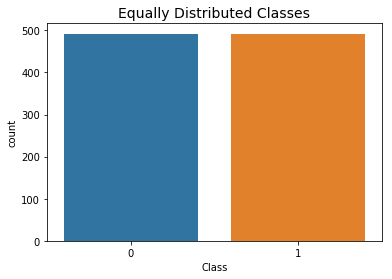

In [12]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['Class'].value_counts()/len(new_df))



sns.countplot('Class', data=new_df)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()

<h3> Correlation Matrices </h3>
Correlation matrices are the essence of understanding our data. We want to know if there are features that influence heavily in whether a specific transaction is a fraud. However, it is important that we use the correct dataframe (subsample)  in order for us to see which features have a high positive or negative correlation with regards to fraud transactions.

### Summary and Explanation: 
<ul>
<li><b>Negative Correlations: </b>V17, V14, V12 and V10 are negatively correlated. Notice how the lower these values are, the more likely the end result will be a fraud transaction.  </li>
<li> <b> Positive Correlations: </b> V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction. </li>
<li> <b>BoxPlots: </b>  We will use boxplots to have a better understanding of the distribution of these features in fradulent and non fradulent transactions. </li>
</ul>


**Note: ** We have to make sure we use the subsample in our correlation matrix or else our correlation matrix will be affected by the high imbalance between our classes. This occurs due to the high class imbalance in the original dataframe.

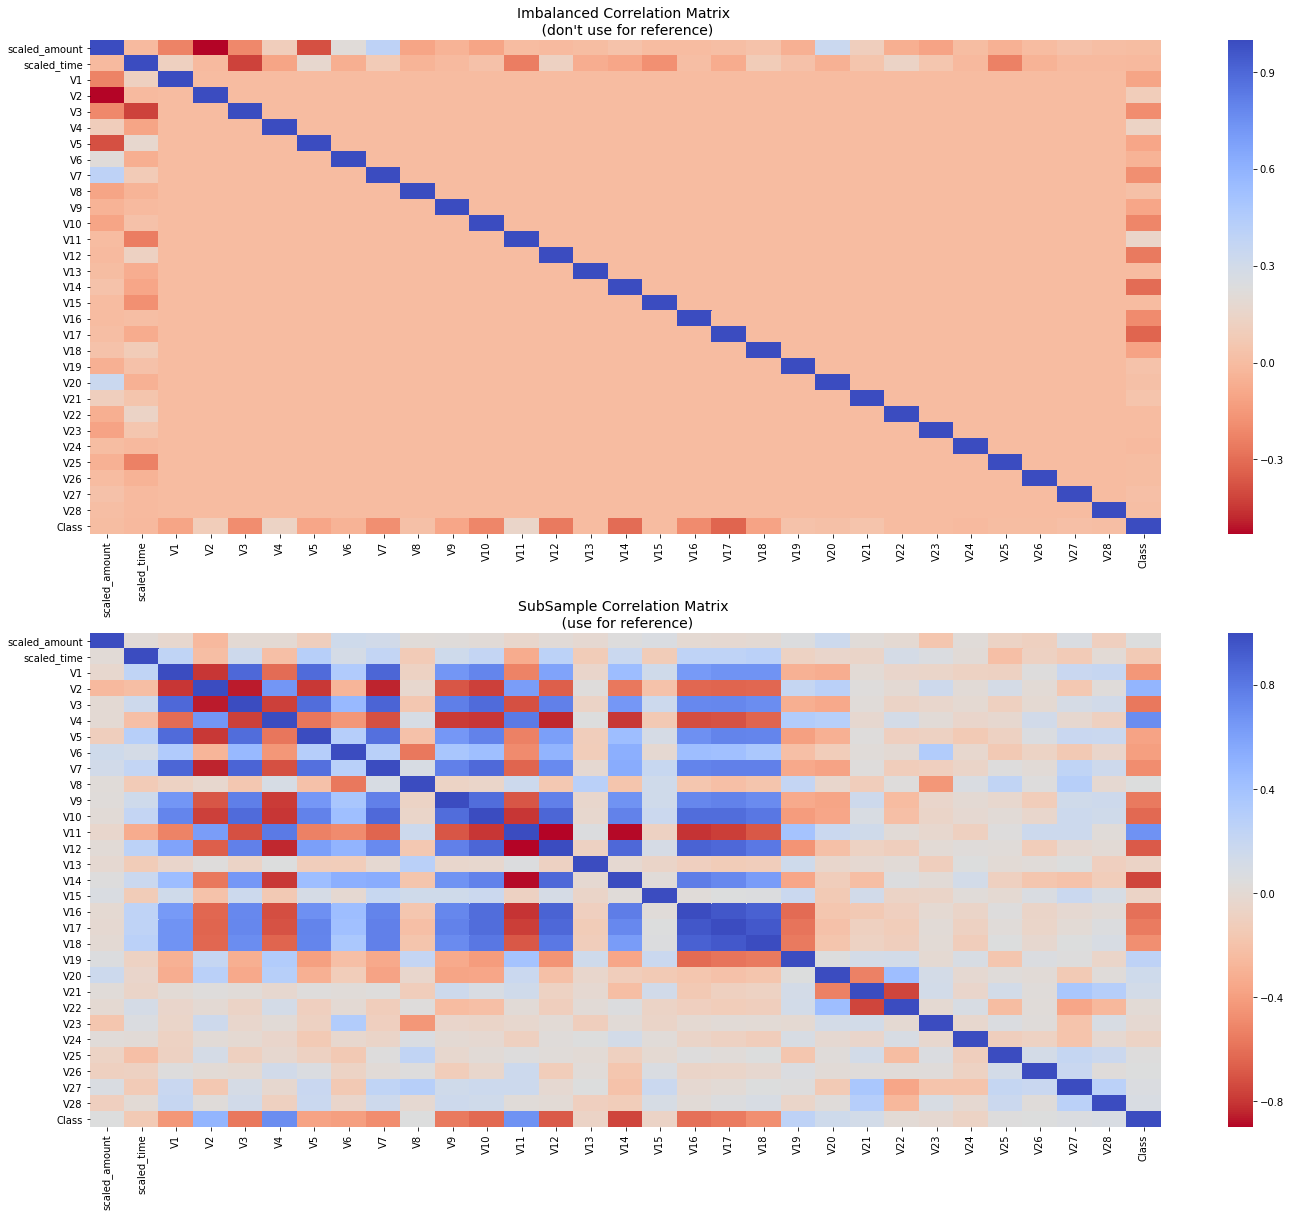

In [13]:
# Make sure we use the subsample in our correlation

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

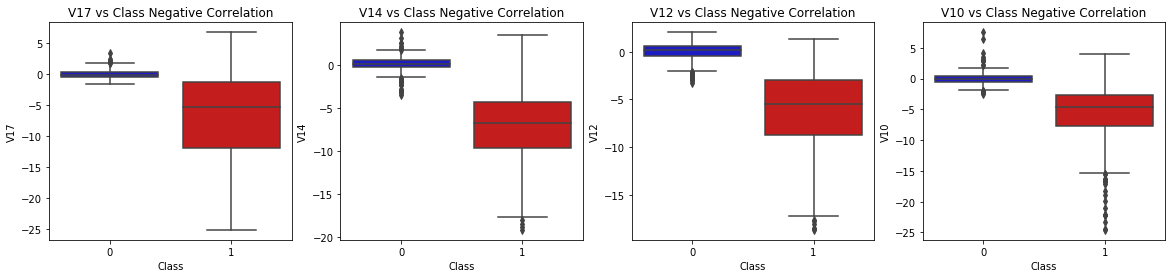

In [14]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))
colors = ["#0101DF", "#DF0101"]
# Negative Correlations with our Class (The lower our feature value the more likely it will be a fraud transaction)
sns.boxplot(x="Class", y="V17", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V17 vs Class Negative Correlation')

sns.boxplot(x="Class", y="V14", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V14 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V12", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V12 vs Class Negative Correlation')


sns.boxplot(x="Class", y="V10", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V10 vs Class Negative Correlation')


plt.show()

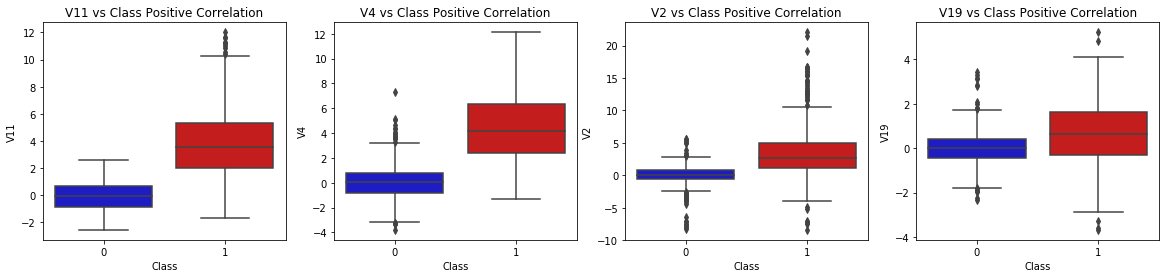

In [15]:
f, axes = plt.subplots(ncols=4, figsize=(20,4))

# Positive correlations (The higher the feature the probability increases that it will be a fraud transaction)
sns.boxplot(x="Class", y="V11", data=new_df, palette=colors, ax=axes[0])
axes[0].set_title('V11 vs Class Positive Correlation')

sns.boxplot(x="Class", y="V4", data=new_df, palette=colors, ax=axes[1])
axes[1].set_title('V4 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V2", data=new_df, palette=colors, ax=axes[2])
axes[2].set_title('V2 vs Class Positive Correlation')


sns.boxplot(x="Class", y="V19", data=new_df, palette=colors, ax=axes[3])
axes[3].set_title('V19 vs Class Positive Correlation')

plt.show()

## Anomaly Detection:
<a id="anomaly"></a>



Our main aim in this section is to remove "extreme outliers" from features that have a high correlation with our classes. This will have a positive impact on the accuracy of our models.  <br><br>


### Interquartile Range Method:
<ul>
<li> <b>Interquartile Range (IQR): </b> We calculate this by the difference between the 75th percentile and 25th percentile. Our aim is to create a threshold beyond the 75th and 25th percentile that in case some instance pass this threshold the instance will be deleted.  </li>
<li> <b>Boxplots: </b> Besides easily seeing the 25th and 75th percentiles (both end of the squares) it is also easy to see extreme outliers (points beyond the lower and higher extreme). </li>
</ul>

### Outlier Removal Tradeoff:
We have to be careful as to how far do we want the threshold for removing outliers. We determine the threshold by multiplying a number (ex: 1.5) by the (Interquartile Range). The higher this threshold is, the less outliers will detect (multiplying by a higher number ex: 3), and the lower this threshold is the more outliers it will detect.  <br><br>

### Tradeoff
The lower the threshold the more outliers it will remove however, we want to focus more on "extreme outliers" rather than just outliers. Why? because we might run the risk of information loss which will cause our models to have a lower accuracy. You can play with this threshold and see how it affects the accuracy of our classification models.


### Summary:
<ul>
<li> <b> Visualize Distributions: </b> We first start by visualizing the distribution of the feature we are going to use to eliminate some of the outliers. V14 is the only feature that has a Gaussian distribution compared to features V12 and V10. </li>
<li><b>Determining the threshold: </b> After we decide which number we will use to multiply with the iqr (the lower more outliers removed), we will proceed in determining the upper and lower thresholds by substrating q25 - threshold (lower extreme threshold) and adding q75 + threshold (upper extreme threshold). </li>
<li> <b>Conditional Dropping: </b> Lastly, we create a conditional dropping stating that if the "threshold" is exceeded in both extremes, the instances will be removed. </li>
<li> <b> Boxplot Representation: </b> Visualize through the boxplot that the number of "extreme outliers" have been reduced to a considerable amount. </li>
</ul>



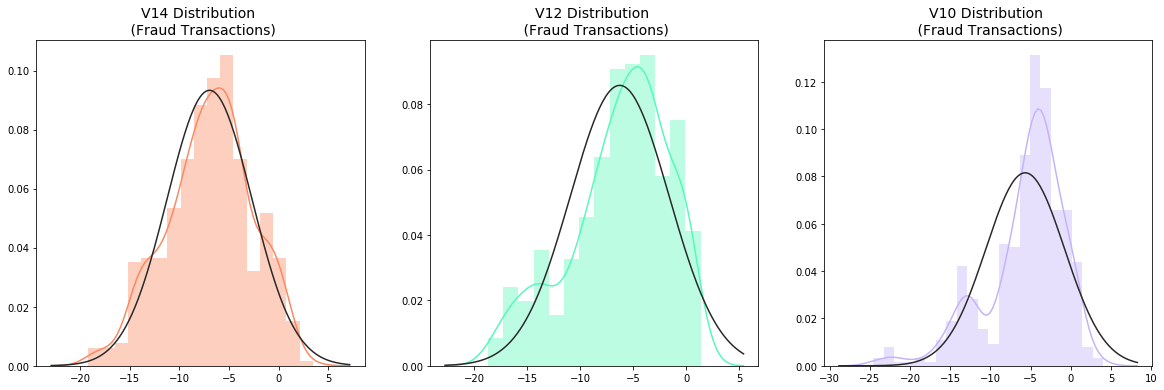

In [16]:
from scipy.stats import norm

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize=(20, 6))

v14_fraud_dist = new_df['V14'].loc[new_df['Class'] == 1].values
sns.distplot(v14_fraud_dist,ax=ax1, fit=norm, color='#FB8861')
ax1.set_title('V14 Distribution \n (Fraud Transactions)', fontsize=14)

v12_fraud_dist = new_df['V12'].loc[new_df['Class'] == 1].values
sns.distplot(v12_fraud_dist,ax=ax2, fit=norm, color='#56F9BB')
ax2.set_title('V12 Distribution \n (Fraud Transactions)', fontsize=14)


v10_fraud_dist = new_df['V10'].loc[new_df['Class'] == 1].values
sns.distplot(v10_fraud_dist,ax=ax3, fit=norm, color='#C5B3F9')
ax3.set_title('V10 Distribution \n (Fraud Transactions)', fontsize=14)

plt.show()

In [17]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = new_df['V14'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
print('Quartile 25: {} | Quartile 75: {}'.format(q25, q75))
v14_iqr = q75 - q25
print('iqr: {}'.format(v14_iqr))

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
print('Cut Off: {}'.format(v14_cut_off))
print('V14 Lower: {}'.format(v14_lower))
print('V14 Upper: {}'.format(v14_upper))

outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
print('Feature V14 Outliers for Fraud Cases: {}'.format(len(outliers)))
print('V14 outliers:{}'.format(outliers))

new_df = new_df.drop(new_df[(new_df['V14'] > v14_upper) | (new_df['V14'] < v14_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)

# -----> V12 removing outliers from fraud transactions
v12_fraud = new_df['V12'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
print('V12 Lower: {}'.format(v12_lower))
print('V12 Upper: {}'.format(v12_upper))
outliers = [x for x in v12_fraud if x < v12_lower or x > v12_upper]
print('V12 outliers: {}'.format(outliers))
print('Feature V12 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V12'] > v12_upper) | (new_df['V12'] < v12_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))
print('----' * 44)


# Removing outliers V10 Feature
v10_fraud = new_df['V10'].loc[new_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5     
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
print('V10 Lower: {}'.format(v10_lower))
print('V10 Upper: {}'.format(v10_upper))
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
print('V10 outliers: {}'.format(outliers))
print('Feature V10 Outliers for Fraud Cases: {}'.format(len(outliers)))
new_df = new_df.drop(new_df[(new_df['V10'] > v10_upper) | (new_df['V10'] < v10_lower)].index)
print('Number of Instances after outliers removal: {}'.format(len(new_df)))

Quartile 25: -9.692722964972385 | Quartile 75: -4.282820849486866
iqr: 5.409902115485519
Cut Off: 8.114853173228278
V14 Lower: -17.807576138200663
V14 Upper: 3.8320323237414122
Feature V14 Outliers for Fraud Cases: 4
V14 outliers:[-18.4937733551053, -18.8220867423816, -19.2143254902614, -18.049997689859396]
Number of Instances after outliers removal: 980
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V12 Lower: -17.3430371579634
V12 Upper: 5.776973384895937
V12 outliers: [-18.4311310279993, -18.683714633344298, -18.047596570821604, -18.553697009645802]
Feature V12 Outliers for Fraud Cases: 4
Number of Instances after outliers removal: 976
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
V10 Lower: -14.89885463232024
V10 Upper: 4.920

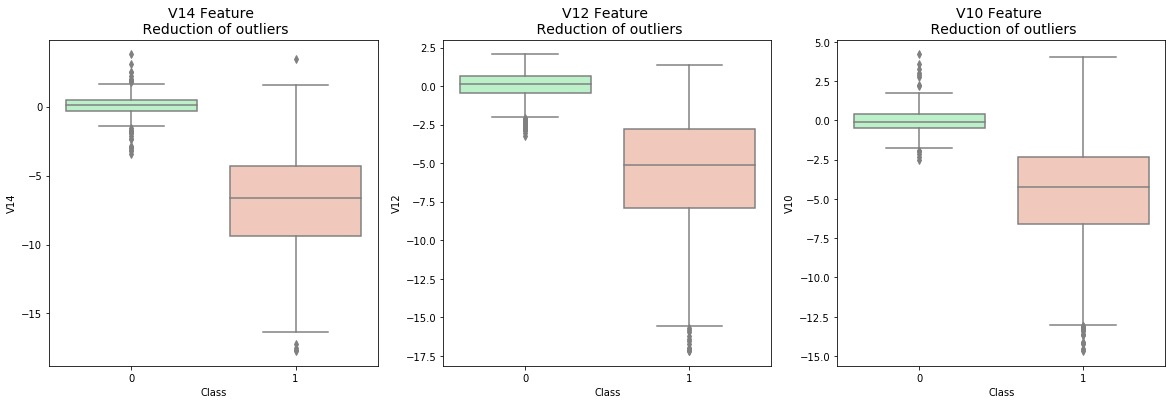

In [18]:
f,(ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,6))

colors = ['#B3F9C5', '#f9c5b3']
# Boxplots with outliers removed
# Feature V14
sns.boxplot(x="Class", y="V14", data=new_df,ax=ax1, palette=colors)
ax1.set_title("V14 Feature \n Reduction of outliers", fontsize=14)
# ax1.annotate('Fewer extreme \n outliers', xy=(0.98, -17.5), xytext=(0, -12),
#             arrowprops=dict(facecolor='black'),
#             fontsize=14)

# Feature 12
sns.boxplot(x="Class", y="V12", data=new_df, ax=ax2, palette=colors)
ax2.set_title("V12 Feature \n Reduction of outliers", fontsize=14)

# Feature V10
sns.boxplot(x="Class", y="V10", data=new_df, ax=ax3, palette=colors)
ax3.set_title("V10 Feature \n Reduction of outliers", fontsize=14)


plt.show()

<h2>Dimensionality Reduction and Clustering: </h2>

<h3> Summary: </h3>
<ul> 
<li>t-SNE algorithm can pretty accurately cluster the cases that were fraud and non-fraud in our dataset. </li>
<li> Although the subsample is pretty small, the t-SNE algorithm is able to detect clusters pretty accurately in every scenario (I shuffle the dataset before running t-SNE)</li>
<li> This gives us an indication that further predictive models will perform pretty well in separating fraud cases from non-fraud cases. </li>
</ul>

In [19]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('Class', axis=1)
y = new_df['Class']


# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))

# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))

# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))

T-SNE took 7.2 s
PCA took 0.023 s
Truncated SVD took 0.0054 s


In [20]:
X_reduced_tsne # reduced to 2 dimensional data

array([[  6.6139097, -27.13568  ],
       [ -2.9633818, -27.4545   ],
       [ 10.002154 , -26.946201 ],
       ...,
       [ 32.609467 , -13.740008 ],
       [-27.402033 ,   2.0621283],
       [ -3.3548627, -27.783972 ]], dtype=float32)

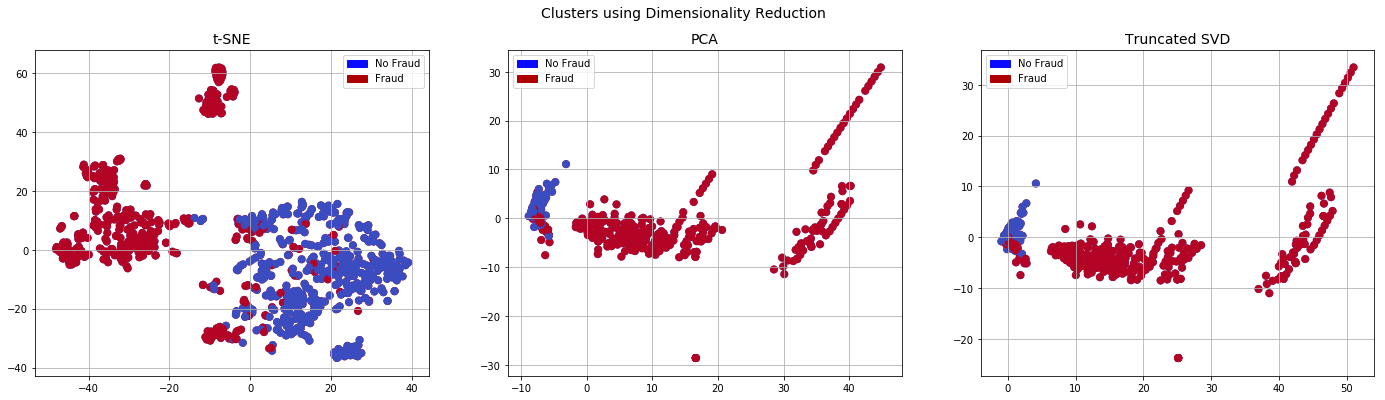

In [21]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Fraud')
red_patch = mpatches.Patch(color='#AF0000', label='Fraud')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)


ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Fraud', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Fraud', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

<h2> Classifiers (UnderSampling):  </h2>
<a id="classifiers"></a>
In this section we will train four types of classifiers and decide which classifier will be more effective in detecting <b>fraud transactions</b>.  Before we have to split our data into training and testing sets and separate the features from the labels.

## Summary: 
<ul>
<li> <b> Logistic Regression </b> classifier is more accurate than the other three classifiers in most cases. (We will further analyze Logistic Regression) </li>
<li><b> GridSearchCV </b> is used to determine the paremeters that gives the best predictive score for the classifiers. </li>
<li> Logistic Regression has the best Receiving Operating Characteristic score  (ROC), meaning that LogisticRegression pretty accurately separates <b> fraud </b> and <b> non-fraud </b> transactions.</li>
</ul>

## Learning Curves:
<ul>
<li>The <b>wider the  gap</b>  between the training score and the cross validation score, the more likely your model is <b>overfitting (high variance)</b>.</li>
<li> If the score is low in both training and cross-validation sets</b> this is an indication that our model is <b>underfitting (high bias)</b></li>
<li><b> Logistic Regression Classifier</b>  shows the best score in both training and cross-validating sets.</li>
</ul>

In [22]:
# Undersampling before cross validating (prone to overfit)
X = new_df.drop('Class', axis=1)
y = new_df['Class']

In [23]:
# Our data is already scaled we should split our training and test sets
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [24]:
# Turn the values into an array for feeding the classification algorithms.
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

In [25]:
classifiers={
    'LogisticRegression':LogisticRegression(),
    'KNearest':KNeighborsClassifier(),
    'Support Vector Classifier':SVC(),
    'DecisionTreeClassifier':DecisionTreeClassifier()
}

In [26]:
# scores are getting even high scores even when applying cross validation.
from sklearn.model_selection import cross_val_score

for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 93.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 92.0 % accuracy score
Classifiers:  SVC Has a training score of 92.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 88.0 % accuracy score


In [27]:
# Use GridSearchCV to find the best parameters.
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

In [28]:
# Overfitting Case

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

Logistic Regression Cross Validation Score:  93.39%
Knears Neighbors Cross Validation Score 92.34%
Support Vector Classifier Cross Validation Score 92.74%
DecisionTree Classifier Cross Validation Score 91.28%


## UNDER SAMPLING DURING CROSS VALIDATION - NEARMISS ALGO

In [51]:
# We will undersample during cross validating
undersample_X = df.drop('Class', axis=1)
undersample_y = df['Class']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(sampling_strategy='majority'), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(undersample_Xtrain[test], undersample_ytrain[test]))
    undersample_precision.append(precision_score(undersample_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(undersample_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(undersample_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(undersample_ytrain[test], undersample_prediction))

Train: [ 42794  43862  44163 ... 284804 284805 284806] Test: [    0     1     2 ... 56984 56985 56986]
Train: [     0      1      2 ... 284804 284805 284806] Test: [ 42794  43862  44163 ... 113931 113932 113933]
Train: [     0      1      2 ... 284804 284805 284806] Test: [108425 108894 109130 ... 170894 170895 170896]
Train: [     0      1      2 ... 284804 284805 284806] Test: [163112 163304 163681 ... 227860 227861 227862]
Train: [     0      1      2 ... 227860 227861 227862] Test: [218875 219172 220653 ... 284804 284805 284806]
NearMiss Label Distribution: Counter({0: 492, 1: 492})


In [41]:
# Let's Plot LogisticRegression Learning Curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    
    # Fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("Decision Tree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt


<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.6/site-packages/matplotlib/pyplot.py'>

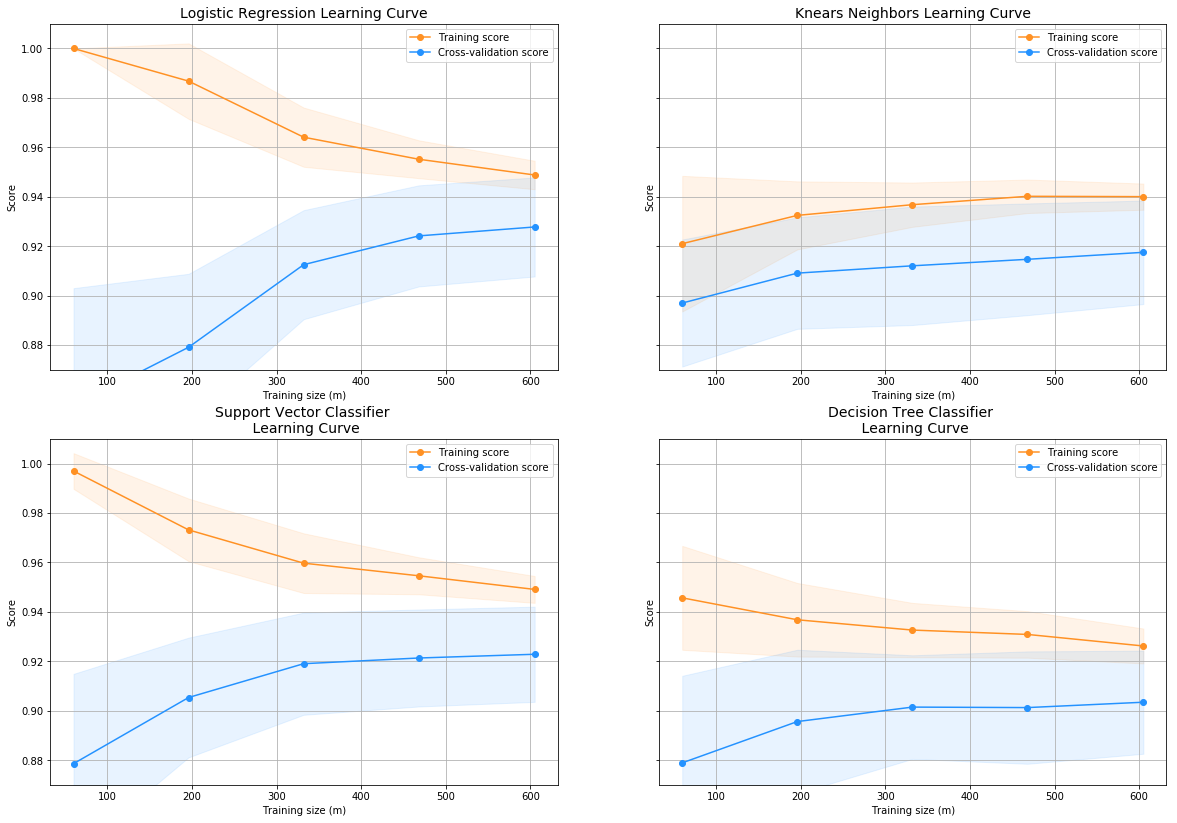

In [42]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [43]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.
# the models with best params from gridsearch are being validated against X_train,y_train which is the entire
#data after it has undergone shuffling

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

In [44]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))

Logistic Regression:  0.9641203703703705
KNears Neighbors:  0.9192866161616161
Support Vector Classifier:  0.9670454545454545
Decision Tree Classifier:  0.9079229797979798


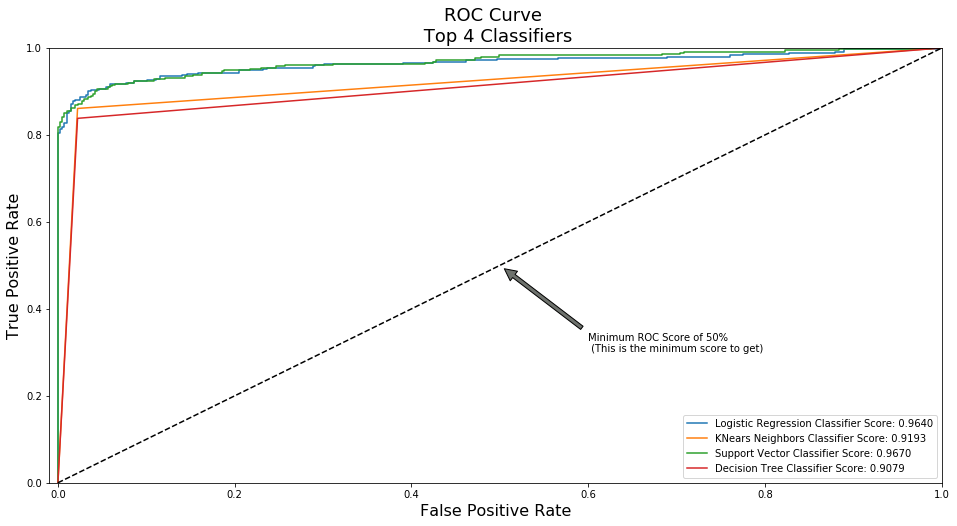

In [37]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

## A Deeper Look into LogisticRegression:
<a id="logistic"></a>
In this section we will ive a deeper look into the <b> logistic regression classifier</b>.


### Terms:
<ul>
<li><b>True Positives:</b> Correctly Classified Fraud Transactions </li>
<li><b>False Positives:</b> Incorrectly Classified Fraud Transactions</li>
<li> <b>True Negative:</b> Correctly Classified Non-Fraud Transactions</li>
<li> <b>False Negative:</b> Incorrectly Classified Non-Fraud Transactions</li>
<li><b>Precision: </b>  True Positives/(True Positives + False Positives)  </li>
<li><b> Recall: </b> True Positives/(True Positives + False Negatives)   </li>
<li> Precision as the name says, says how precise (how sure) is our model in detecting fraud transactions while recall is the amount of fraud cases our model is able to detect.</li>
<li><b>Precision/Recall Tradeoff: </b> The more precise (selective) our model is, the less cases it will detect. Example: Assuming that our model has a precision of 95%, Let's say there are only 5 fraud cases in which the model is 95% precise or more that these are fraud cases. Then let's say there are 5 more cases that our model considers 90% to be a fraud case, if we lower the precision there are more cases that our model will be able to detect. </li>
</ul>

### Summary:
<ul>
<li> <b>Precision starts to descend</b> between 0.90 and 0.92 nevertheless, our precision score is still pretty high and still we have a descent recall score. </li>

</ul>

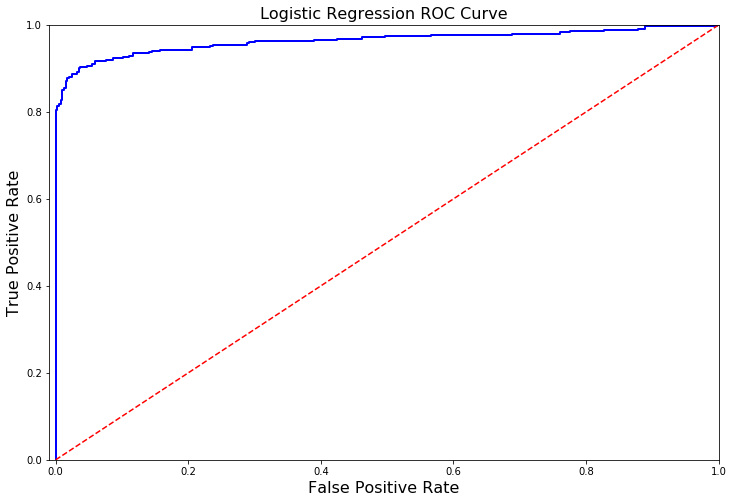

In [45]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [49]:
from sklearn.metrics import precision_recall_curve
precision,recall,threshold=precision_recall_curve(y_train,log_reg_pred)

In [53]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.92
Precision Score: 0.63
F1 Score: 0.75
Accuracy Score: 0.71
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.51
Precision Score: 0.00
Recall Score: 0.94
F1 Score: 0.01
---------------------------------------------------------------------------------------------------------------------------------------


In [54]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [55]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.02


Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.02')

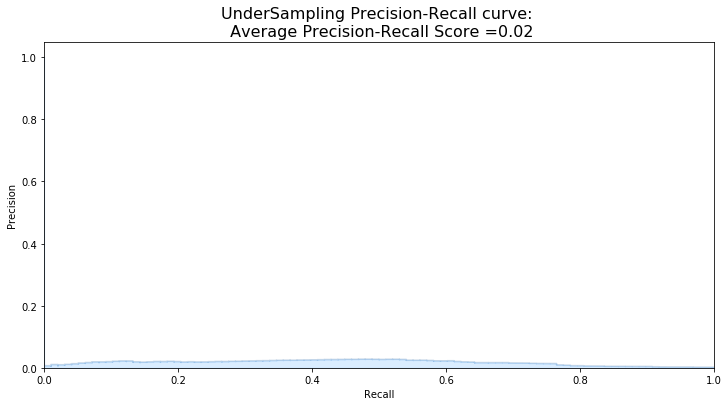

In [56]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

### SMOTE Technique (Over-Sampling):
<a id="smote"></a>
<img src="https://raw.githubusercontent.com/rikunert/SMOTE_visualisation/master/SMOTE_R_visualisation_3.png", width=800>
<b>SMOTE</b> stands for Synthetic Minority Over-sampling Technique.  Unlike Random UnderSampling, SMOTE creates new synthetic points in order to have an equal balance of the classes. This is another alternative for solving the "class imbalance problems". <br><br>


<b> Understanding SMOTE: </b>
<ul>
<li> <b> Solving the Class Imbalance: </b> SMOTE creates synthetic points from the minority class in order to reach an equal balance between the minority and majority class. </li>
<li><b>Location of the synthetic points: </b>   SMOTE picks the distance between the closest neighbors of the minority class, in between these distances it creates synthetic points. </li>
<li> <b>Final Effect:  </b> More information is retained since we didn't have to delete any rows unlike in random undersampling.</li>
<li><b> Accuracy || Time Tradeoff: </b> Although it is likely that SMOTE will be more accurate than random under-sampling, it will take more time to train since no rows are eliminated as previously stated.</li>

</ul>

### Cross Validation Overfitting Mistake:
## Overfitting during Cross Validation:  
In our undersample analysis I want to show you a common mistake I made that I want to share with all of you. It is simple, if you want to undersample or oversample your data you should not do it before cross validating. Why because you will be directly influencing the validation set before implementing cross-validation causing a "data leakage" problem. <b>In the following section you will see amazing precision and recall scores but in reality our data is overfitting!</b>
### The Wrong Way:
<img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/2639934.jpg?401"><br>

As mentioned previously, if we get the minority class ("Fraud) in our case, and create the synthetic points before cross validating we have a certain influence on the "validation set" of the cross validation process. Remember how cross validation works, let's assume we are splitting the data into 5 batches, 4/5 of the dataset will be the training set while 1/5 will be the validation set. The test set should not be touched! For that reason, we have to do the creation of synthetic datapoints "during" cross-validation and not before, just like below: <br>


### The Right Way:
<img src="https://www.marcoaltini.com/uploads/1/3/2/3/13234002/9101820.jpg?372"> <br>
As you see above, SMOTE occurs "during" cross validation and not "prior" to the cross validation process. Synthetic data are created only for the training set without affecting the validation set.




**References**: 
<ul>
<li><a src="https://www.marcoaltini.com/blog/dealing-with-imbalanced-data-undersampling-oversampling-and-proper-cross-validation"> 
DEALING WITH IMBALANCED DATA: UNDERSAMPLING, OVERSAMPLING AND PROPER CROSS-VALIDATION </a></li> 

<li> <a src="http://rikunert.com/SMOTE_explained "> SMOTE explained for noobs  </a></li>
<li> <a src="https://www.youtube.com/watch?v=DQC_YE3I5ig&t=794s"> Machine Learning - Over-& Undersampling - Python/ Scikit/ Scikit-Imblearn </a></li>
</ul>

## SMOTE UNDERSAMPLING

In [58]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()

#this is the data that was stratified sampled earlier on


rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(sampling_strategy='minority'), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 227846 | Length of y (train): 227846
Length of X (test): 56961 | Length of y (test): 56961
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.9599425152657017
precision: 0.05634708365021338
recall: 0.9111002921129504
f1: 0.10484307079646085
---------------------------------------------------------------------------------------------------------------------------------------


In [59]:
labels = ['No Fraud', 'Fraud']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

    No Fraud       1.00      0.98      0.99     56863
       Fraud       0.06      0.87      0.11        98

    accuracy                           0.98     56961
   macro avg       0.53      0.92      0.55     56961
weighted avg       1.00      0.98      0.99     56961



In [60]:
y_score = best_est.decision_function(original_Xtest)

In [61]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.69


Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.69')

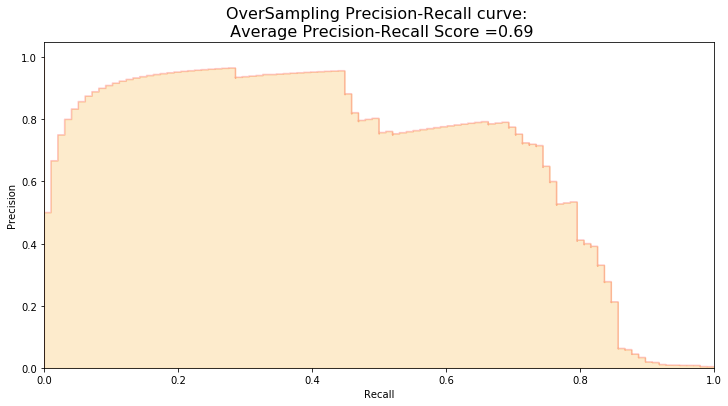

In [62]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

## SMOTE OVERSAMPLING

In [63]:
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(ratio='minority', random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)


# This will be the data were we are going to 
Xsm_train, ysm_train = sm.fit_resample(original_Xtrain, original_ytrain)


In [64]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :30.63550066947937 sec


# Test Data with Logistic Regression:
<a id="testing_logistic"></a>
## Confusion Matrix:
**Positive/Negative:** Type of Class (label) ["No", "Yes"]
**True/False:** Correctly or Incorrectly classified by the model.<br><br>

**True Negatives (Top-Left Square):** This is the number of **correctly** classifications of the "No" (No Fraud Detected) class. <br><br>

**False Negatives (Top-Right Square):** This is the number of **incorrectly** classifications of the "No"(No Fraud Detected) class. <br><br>

**False Positives (Bottom-Left Square):** This is the number of **incorrectly** classifications of the "Yes" (Fraud Detected) class <br><br>

**True Positives (Bottom-Right Square):** This is the number of **correctly** classifications of the "Yes" (Fraud Detected) class.


### Summary: 
<ul>
<li> <b>Random UnderSampling:</b> We will evaluate the final performance of the classification models in the random undersampling subset. <b>Keep in mind that this is not the data from the original dataframe. </b> </li>
<li> <b>Classification Models: </b> The models that performed the best were <b>logistic regression </b> and <b>support vector classifier (SVM)</b>  </li>
</ul>

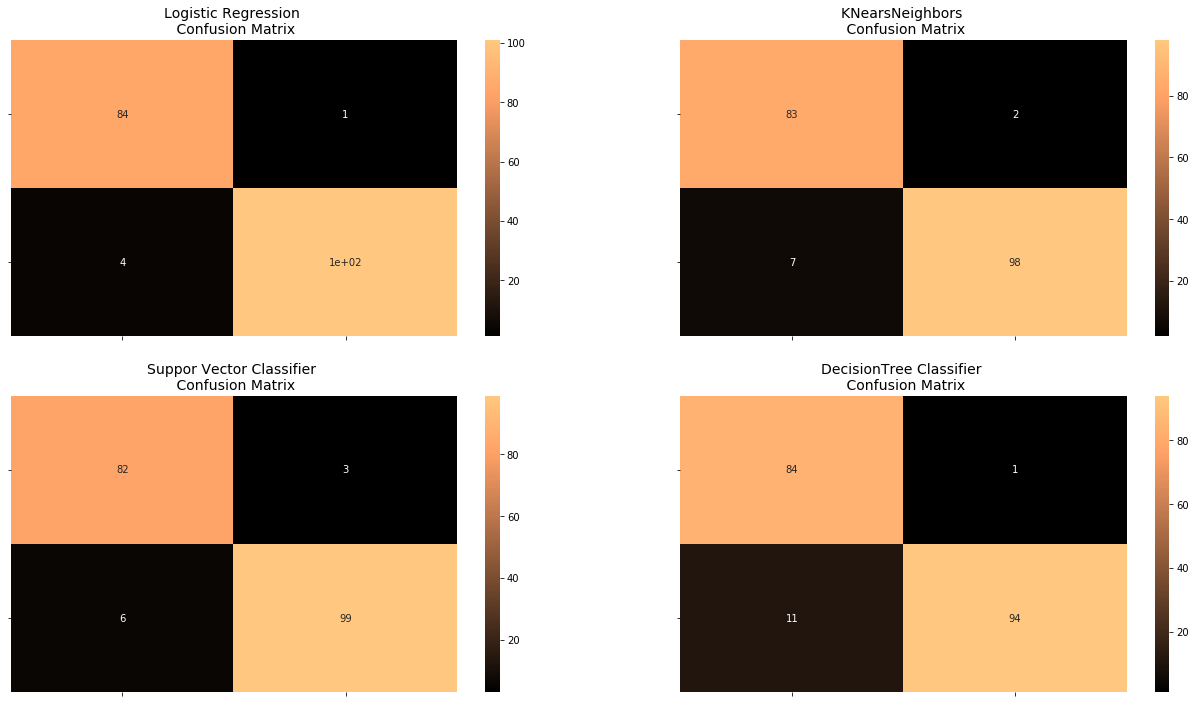

In [65]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)

#test is always done on original test set though the model was fit on sampled data
log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [66]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_tree))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97        85
           1       0.99      0.96      0.98       105

    accuracy                           0.97       190
   macro avg       0.97      0.98      0.97       190
weighted avg       0.97      0.97      0.97       190

KNears Neighbors:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        85
           1       0.98      0.93      0.96       105

    accuracy                           0.95       190
   macro avg       0.95      0.95      0.95       190
weighted avg       0.95      0.95      0.95       190

Support Vector Classifier:
              precision    recall  f1-score   support

           0       0.93      0.96      0.95        85
           1       0.97      0.94      0.96       105

    accuracy                           0.95       190
   macro avg       0.95      0.95      0.95       190
weighted

In [67]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading! 
final_df

,Technique,Score
0,Random UnderSampling,0.973684
1,Oversampling (SMOTE),0.976019


## Neural Networks Testing Random UnderSampling Data vs OverSampling (SMOTE): 
<a id="neural_networks"></a>
In this section we will implement a simple Neural Network (with one hidden layer) in order to see  which of the two logistic regressions models we implemented in the (undersample or oversample(SMOTE)) has a better accuracy for detecting fraud and non-fraud transactions. <br><br>

### Our Main Goal:
Our main goal is to explore how our simple neural network behaves in both the random undersample and oversample dataframes and see whether they can predict accuractely both non-fraud and fraud cases. Why not only focus on fraud? Imagine you were a cardholder and after you purchased an item your card gets blocked because the bank's algorithm thought your purchase was a fraud. That's why we shouldn't emphasize only in detecting fraud cases but we should also emphasize correctly categorizing non-fraud transactions.


### The Confusion Matrix:
Here is again, how the confusion matrix works:
<ul>
<li><b>Upper Left Square: </b> The amount of <b>correctly</b> classified by our model of  no fraud transactions. </li>
<li> <b>Upper Right Square:</b> The amount of  <b>incorrectly </b> classified transactions as fraud cases, but the actual label is <b> no fraud </b>. </li>
<li><b>Lower Left Square:</b> The amount of <b> incorrectly </b> classified transactions as no fraud cases, but the actual label is <b>fraud </b>. </li>
<li><b> Lower Right Square:</b> The amount of  <b>correctly</b> classified by our model of fraud transactions. </li>
</ul>

### Summary (Keras || Random UnderSampling):
<ul>
<li><b>Dataset: </b> In this final phase of testing we will fit this model in both the <b>random undersampled subset</b>  and <b> oversampled dataset (SMOTE) </b>in order to predict the final result using the <b>original dataframe testing data.</b> </li>
<li>  <b>Neural Network Structure: </b> As stated previously, this will be a simple model composed of one input layer (where the number of nodes equals the number of features) plus bias node, one hidden layer with 32 nodes and one output node composed of two possible results 0 or 1 (No fraud or fraud). </li>
<li> <b>Other characteristics:</b> The learning rate will be 0.001, the optimizer we will use is the AdamOptimizer, the activation function that is used in this scenario is "Relu" and for the final outputs we will use sparse categorical cross entropy, which gives the probability whether an instance case is no fraud or fraud (The prediction will pick the highest probability between the two.) </li>
</ul>


In [68]:
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Activation
from keras.layers.core import Dense
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

n_inputs = X_train.shape[1]

undersample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

Using TensorFlow backend.


In [69]:
undersample_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                930       
_________________________________________________________________
dense_2 (Dense)              (None, 32)                992       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 66        
Total params: 1,988
Trainable params: 1,988
Non-trainable params: 0
_________________________________________________________________


In [70]:
undersample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [71]:
undersample_model.fit(X_train, y_train, validation_split=0.2, batch_size=25, epochs=20, shuffle=True, verbose=2)

Train on 605 samples, validate on 152 samples
Epoch 1/20
 - 0s - loss: 0.6099 - acc: 0.6959 - val_loss: 0.4193 - val_acc: 0.8092
Epoch 2/20
 - 0s - loss: 0.3576 - acc: 0.9074 - val_loss: 0.3619 - val_acc: 0.9145
Epoch 3/20
 - 0s - loss: 0.2857 - acc: 0.9107 - val_loss: 0.3189 - val_acc: 0.9145
Epoch 4/20
 - 0s - loss: 0.2339 - acc: 0.9306 - val_loss: 0.2940 - val_acc: 0.9276
Epoch 5/20
 - 0s - loss: 0.1997 - acc: 0.9339 - val_loss: 0.2909 - val_acc: 0.9276
Epoch 6/20
 - 0s - loss: 0.1736 - acc: 0.9355 - val_loss: 0.2884 - val_acc: 0.9276
Epoch 7/20
 - 0s - loss: 0.1538 - acc: 0.9455 - val_loss: 0.2846 - val_acc: 0.9276
Epoch 8/20
 - 0s - loss: 0.1400 - acc: 0.9455 - val_loss: 0.3069 - val_acc: 0.9211
Epoch 9/20
 - 0s - loss: 0.1290 - acc: 0.9488 - val_loss: 0.3043 - val_acc: 0.9276
Epoch 10/20
 - 0s - loss: 0.1205 - acc: 0.9537 - val_loss: 0.3178 - val_acc: 0.9276
Epoch 11/20
 - 0s - loss: 0.1130 - acc: 0.9521 - val_loss: 0.3278 - val_acc: 0.9276
Epoch 12/20
 - 0s - loss: 0.1068 - acc:

In [72]:
undersample_predictions = undersample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [73]:
undersample_fraud_predictions = undersample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

In [74]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[54496  2367]
 [    5    93]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


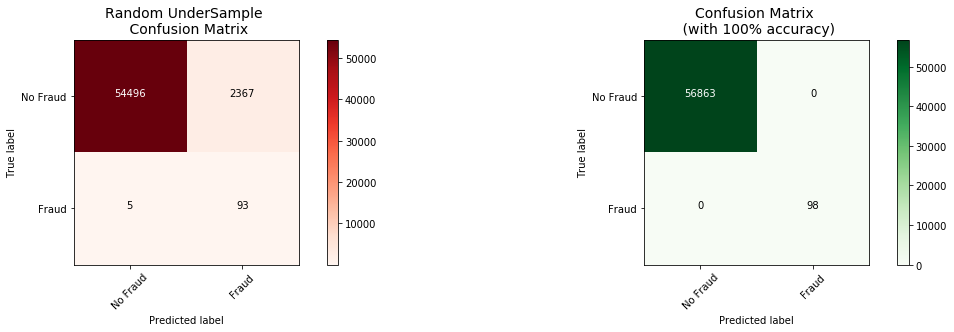

In [75]:
undersample_cm = confusion_matrix(original_ytest, undersample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(undersample_cm, labels, title="Random UnderSample \n Confusion Matrix", cmap=plt.cm.Reds)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)

### Keras || OverSampling (SMOTE):


In [76]:
n_inputs = Xsm_train.shape[1]

oversample_model = Sequential([
    Dense(n_inputs, input_shape=(n_inputs, ), activation='relu'),
    Dense(32, activation='relu'),
    Dense(2, activation='softmax')
])

In [77]:
oversample_model.compile(Adam(lr=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [78]:
oversample_model.fit(Xsm_train, ysm_train, validation_split=0.2, batch_size=300, epochs=20, shuffle=True, verbose=2)

Train on 363923 samples, validate on 90981 samples
Epoch 1/20
 - 3s - loss: 0.0616 - acc: 0.9793 - val_loss: 0.0211 - val_acc: 0.9954
Epoch 2/20
 - 2s - loss: 0.0126 - acc: 0.9973 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 3/20
 - 2s - loss: 0.0074 - acc: 0.9987 - val_loss: 0.0038 - val_acc: 1.0000
Epoch 4/20
 - 2s - loss: 0.0058 - acc: 0.9991 - val_loss: 0.0020 - val_acc: 0.9999
Epoch 5/20
 - 2s - loss: 0.0048 - acc: 0.9993 - val_loss: 0.0016 - val_acc: 0.9999
Epoch 6/20
 - 2s - loss: 0.0043 - acc: 0.9994 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 7/20
 - 2s - loss: 0.0039 - acc: 0.9994 - val_loss: 0.0012 - val_acc: 1.0000
Epoch 8/20
 - 2s - loss: 0.0034 - acc: 0.9996 - val_loss: 0.0031 - val_acc: 0.9998
Epoch 9/20
 - 3s - loss: 0.0034 - acc: 0.9996 - val_loss: 8.4173e-04 - val_acc: 0.9999
Epoch 10/20
 - 2s - loss: 0.0030 - acc: 0.9996 - val_loss: 5.4998e-04 - val_acc: 1.0000
Epoch 11/20
 - 2s - loss: 0.0033 - acc: 0.9996 - val_loss: 3.1922e-04 - val_acc: 1.0000
Epoch 12/20
 - 2s - lo

In [79]:
oversample_predictions = oversample_model.predict(original_Xtest, batch_size=200, verbose=0)

In [80]:
oversample_fraud_predictions = oversample_model.predict_classes(original_Xtest, batch_size=200, verbose=0)

Confusion matrix, without normalization
[[56845    18]
 [   28    70]]
Confusion matrix, without normalization
[[56863     0]
 [    0    98]]


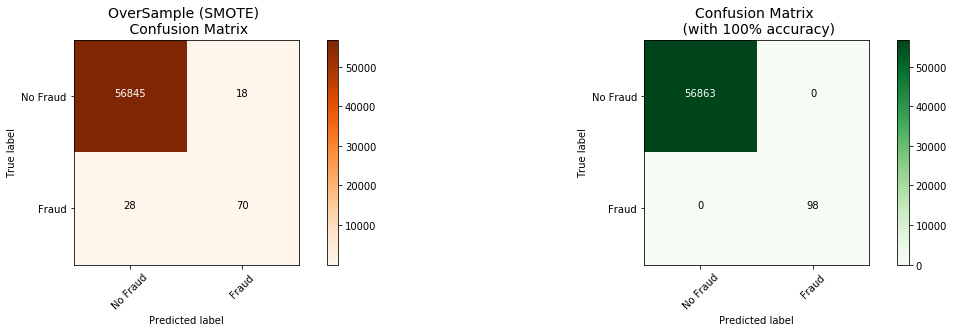

In [81]:
oversample_smote = confusion_matrix(original_ytest, oversample_fraud_predictions)
actual_cm = confusion_matrix(original_ytest, original_ytest)
labels = ['No Fraud', 'Fraud']

fig = plt.figure(figsize=(16,8))

fig.add_subplot(221)
plot_confusion_matrix(oversample_smote, labels, title="OverSample (SMOTE) \n Confusion Matrix", cmap=plt.cm.Oranges)

fig.add_subplot(222)
plot_confusion_matrix(actual_cm, labels, title="Confusion Matrix \n (with 100% accuracy)", cmap=plt.cm.Greens)